## **Fake news prediction**

Now it's time to apply some ML algorithms to our data and try to make a model which can distinguish between fake and real news articles

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore")

In [3]:
news_df = pd.read_csv('news_df_cleaned.csv')

<AxesSubplot:xlabel='classification'>

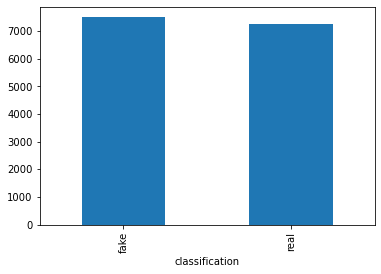

In [4]:
# check we have an even distribution of fake and real news

news_df.groupby(['classification']).size().plot(kind='bar')

In [5]:
fake_df = news_df[news_df['classification'] == 'fake']
real_df = news_df[news_df['classification'] == 'real']

**Convert the clasification column to an integer so the models can process it**

In [6]:
fake_df["class"] = 0
real_df["class"] = 1

**Merging the two dfs into one df again**

In [7]:
df_merged = pd.concat([fake_df, real_df], axis =0 )
df_merged

,headline,text,classification,text_cleaned,text_transformed,headline_cleaned,headline_transformed,class
7262,WikiLeaks: Podesta Had Disturbing ‘Beyond Disc...,"by Baxter Dmitry in News , US // 0 Comments ...",fake,by baxter dmitry in news us comments a new wi...,baxter dmitry news u comment new wikileaks ema...,wikileaks podesta had disturbing beyond discip...,wikileaks podesta disturbing beyond discipline...,0
7263,Trump elected as President – risks and opportu...,"13904 Views November 09, 2016 193 Comments Ana...",fake,views november comments analyses the saker so...,view november comment analysis saker happened ...,trump elected as president risks and opportuni...,trump elected president risk opportunity,0
7264,Break the Silence or Support Self-Determinatio...,B y Danny Haiphong S yria is “the target of on...,fake,b y danny haiphong s yria is the target of one...,b danny haiphong yria target one greatest misi...,break the silence or support self determinatio...,break silence support self determination syria...,0
7265,Re: donald-trump-accepts-the-nomination-public...,Wilderness Survival Copyright © 2016 The Econo...,fake,wilderness survival copyright the economic col...,wilderness survival copyright economic collaps...,re donald trump accepts the nomination public ...,donald trump accepts nomination public domain,0
7266,Re: More Than 101 Million Working Age American...,More Than 101 Million Working Age Americans Do...,fake,more than million working age americans do not...,million working age american job michael snyde...,re more than million working age americans do ...,million working age american job,0
...,...,...,...,...,...,...,...,...
7257,2020 Census Results Show Big Changes to Americ...,"According to the 2020 United States Census, th...",real,according to the united states census the u s ...,according united state census u white hispanic...,census results show big changes to america s ...,census result show big change america racial e...,1
7258,"Dems and GOP Strike Short-Term Deal on Debt, b...",Democrats and Republicans have reached a tempo...,real,democrats and republicans have reached a tempo...,democrat republican reached temporary solution...,dems and gop strike short term deal on debt bu...,dems gop strike short term deal debt larger di...,1
7259,January 6 Committee Votes to Hold Steve Bannon...,"On Tuesday evening, the House Committee invest...",real,on tuesday evening the house committee investi...,tuesday evening house committee investigating ...,january committee votes to hold steve bannon i...,january committee vote hold steve bannon conte...,1
7260,Biden Picks Susan Rice to Lead Domestic Policy...,Statecertified 2020 presidential election winn...,real,statecertified presidential election winner jo...,statecertified presidential election winner jo...,biden picks susan rice to lead domestic policy...,biden pick susan rice lead domestic policy cou...,1


**Dropping the unecessary columns**

In [10]:
df_merged = df_merged.drop(columns=['headline', 'text', 'classification', 
'text_cleaned', 'headline_cleaned'])

KeyError: "['headline' 'text' 'classification' 'text_cleaned' 'headline_cleaned'] not found in axis"

**We can also merge the headlines and text and pass this to the algorithm instead of only the headline or text**

In [11]:
df_merged['headline_text_merged'] = df_merged["headline_transformed"] + df_merged["text_transformed"]
df_merged


,text_transformed,headline_transformed,class,headline_text_merged
7262,baxter dmitry news u comment new wikileaks ema...,wikileaks podesta disturbing beyond discipline...,0,wikileaks podesta disturbing beyond discipline...
7263,view november comment analysis saker happened ...,trump elected president risk opportunity,0,trump elected president risk opportunity view ...
7264,b danny haiphong yria target one greatest misi...,break silence support self determination syria...,0,break silence support self determination syria...
7265,wilderness survival copyright economic collaps...,donald trump accepts nomination public domain,0,donald trump accepts nomination public domain ...
7266,million working age american job michael snyde...,million working age american job,0,million working age american job million worki...
...,...,...,...,...
7257,according united state census u white hispanic...,census result show big change america racial e...,1,census result show big change america racial e...
7258,democrat republican reached temporary solution...,dems gop strike short term deal debt larger di...,1,dems gop strike short term deal debt larger di...
7259,tuesday evening house committee investigating ...,january committee vote hold steve bannon conte...,1,january committee vote hold steve bannon conte...
7260,statecertified presidential election winner jo...,biden pick susan rice lead domestic policy cou...,1,biden pick susan rice lead domestic policy cou...


**Check if we have any nulls in the x column**

In [12]:
df_merged['headline_text_merged'].isna().sum()

92

In [13]:
df_merged['headline_text_merged'] = df_merged['headline_text_merged'].dropna()

**Randomly shuffle df and reset the index**

In [14]:
df_merged = df_merged.sample(frac = 1)


In [15]:
df_merged.reset_index(inplace = True)
df_merged.drop(["index"], axis = 1, inplace = True)
df_merged.head(10)

,text_transformed,headline_transformed,class,headline_text_merged
0,hillary clinton barely lost presidential elect...,hillary clinton huge trouble america noticed s...,0,hillary clinton huge trouble america noticed s...
1,tim brown monday man voted donald trump arrest...,comment texas police arrest trump voter wearin...,0,comment texas police arrest trump voter wearin...
2,colombia government urgently working congress ...,colombia urgently crafting law allow crime gan...,1,colombia urgently crafting law allow crime gan...
3,airline racing clock clear many customer possi...,u airline scramble evacuate resident ahead hur...,1,u airline scramble evacuate resident ahead hur...
4,south korean president moon jaein unveil array...,south korea moon try k pop tv star china charm...,1,south korea moon try k pop tv star china charm...
5,u transportation security administration said ...,u requires enhanced screening cargo turkey,1,u requires enhanced screening cargo turkey u t...
6,canada united state said tuesday cohost meetin...,canada u announce january meeting keep pressur...,1,canada u announce january meeting keep pressur...
7,secretary defense jim mattis indefinitely susp...,pentagon announces suspension military exercis...,1,pentagon announces suspension military exercis...
8,consequence matter one clear message football ...,online safety bill show blurred boundary free ...,1,online safety bill show blurred boundary free ...
9,u president donald trump went around great fir...,forbidden china trump skirt great firewall twe...,1,forbidden china trump skirt great firewall twe...


**X/y split**

In [16]:
# lets test the article text and the headline and see which returns a better result

X = df_merged['headline_text_merged']
y = df_merged['class']

**Testing some different ML algorithms**

- we will try logistic regression, decision tree, random forest, KNN and support vector to classify our data.
- before the classification stage we also need to transform our text into vectors (numeric representations of the text) so that the algorithm can process it.
- i will use the TF IDF vectorizer.
- TF stands for term frequency and is a measure of how frequently a term appears in a document.
- IDF stands for inverse document frequency and is a measure of how important a term is in the corpus.
- this process essentially turns the words into features for the algorithm to process.

In [19]:

def model_tester(X, y):

    # x/y split

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

    # here are the 3 models we will try out

    models = [
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        SVC(),
        KNeighborsClassifier(n_neighbors=3)
    ]

    # we will use a pipeline here to quickly check all 3 models after vectorizing the X data
    # vectorization maps the text to a corresponding vector of real numbers so that it can be processed by a ML algorithm

    for model in models:
        pipe = Pipeline(
            steps=[
            ("tfidf", TfidfVectorizer(lowercase=False, stop_words='english', decode_error='ignore')),
            ("classifier", model),
            ])
        pipe.fit(X_train.values.astype('U'), y_train) 
        # print the scores for each model
        print(model)
        print("model score: %.3f" % pipe.score(X_test.values.astype('U'), y_test))
    



In [22]:
model_tester(X, y)

LogisticRegression()
model score: 0.955
DecisionTreeClassifier()
model score: 0.891
RandomForestClassifier()
model score: 0.955
SVC()
model score: 0.963
KNeighborsClassifier(n_neighbors=3)
model score: 0.906


**The best models are SVC, logistic regression and random forest**

- Lets check the best parameters for each of these models using grid search

In [40]:
# lets start with random forest
def rf_best_params(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
    
    pipe = Pipeline(
        steps= [
        ("tfidf", TfidfVectorizer(lowercase=False, stop_words='english', decode_error='ignore')),
        ("classifier", RandomForestClassifier())
            ])
    pipe.fit(X_train.values.astype('U'), y_train) 

    params = { 
        'tfidf__max_features':[100, 2000],
        'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
        'classifier__n_estimators': [200, 500],
        'classifier__max_features': ['auto', 'sqrt', 'log2'],
        'classifier__max_depth' : [4,5,6,7,8],
        'classifier__criterion' :['gini', 'entropy']}
        
    CV = GridSearchCV(pipe, params, cv= 2, n_jobs= 2, verbose=1)
                  
    CV.fit(X_train.values.astype('U'), y_train)  
    print(CV.best_params_)    
    print(CV.best_score_)

In [41]:
rf_best_params(X, y)

Fitting 2 folds for each of 360 candidates, totalling 720 fits
{'classifier__criterion': 'entropy', 'classifier__max_depth': 8, 'classifier__max_features': 'auto', 'classifier__n_estimators': 200, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 2)}
0.9040565503030136


In [26]:
# find best paramters for logistic regression
def lr_best_params(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
    
    pipe = Pipeline(
        steps= [
        ("tfidf", TfidfVectorizer(lowercase=False, stop_words='english', decode_error='ignore')),
        ("classifier", LogisticRegression())
            ])
    pipe.fit(X_train.values.astype('U'), y_train) 

    params = { 
        'tfidf__max_features':[5000, None],
        'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
        'classifier__C': [0.01, 0.1, 1, 5],
        'classifier__penalty': ['l1', 'l2']
    }
        
        
    CV = GridSearchCV(pipe, params, cv= 2, n_jobs= 2, verbose=1)
                  
    CV.fit(X_train.values.astype('U'), y_train)  
    print(CV.best_params_)    
    print(CV.best_score_)

In [27]:
lr_best_params(X, y)

Fitting 2 folds for each of 48 candidates, totalling 96 fits
{'classifier__C': 5, 'classifier__penalty': 'l2', 'tfidf__max_features': None, 'tfidf__ngram_range': (1, 1)}
0.9546109040154753


In [30]:
# find best paramters for support vector machine
def sv_best_params(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
    
    pipe = Pipeline(
        steps= [
        ("tfidf", TfidfVectorizer(lowercase=False, stop_words='english', decode_error='ignore')),
        ("classifier", SVC())
            ])
    pipe.fit(X_train.values.astype('U'), y_train) 

    params = { 
        'tfidf__max_features':[5000, None],
        'tfidf__ngram_range': [(1, 1), (1, 2), (2, 2)],
        'classifier__C': [0.01, 0.1, 1, 5],
        'classifier__gamma': [1, 0.1, 0.01, 0.001],
        'classifier__kernel': ['rbf', 'sigmoid', 'poly']
    }
        
        
    CV = GridSearchCV(pipe, params, cv= 2, n_jobs= 2, verbose=1)
                  
    CV.fit(X_train.values.astype('U'), y_train)  
    print(CV.best_params_)    
    print(CV.best_score_)

In [31]:
sv_best_params(X,y)

Fitting 2 folds for each of 288 candidates, totalling 576 fits


**Most important features**

- the scores returned from testing different models are all high so we could have overfitting. 
- for the random forest algorithm we can see which features are most important - the features we used are words turned into vectors so each word is essentially a feature. 
- this means we can use this function to see which words have the most predictive power for the rf model.

In [13]:
# the best rf model given above had entropy as the criterion so we will try this with the function.

rf = RandomForestClassifier(criterion='entropy')

In [22]:
def find_imp_features(X, y, classifier):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

    vectorization = TfidfVectorizer()
    vectorizer = vectorization.fit(X_train)
    xv_train = vectorizer.transform(X_train)
    xv_test = vectorizer.transform(X_test)

    classifier.fit(xv_train, y_train)

    new_train_df = pd.DataFrame()
    new_test_df = pd.DataFrame()

    for i, col in enumerate(vectorization.get_feature_names()):
        new_train_df[col] = pd.arrays.SparseArray(xv_train[:, i].toarray().ravel(), fill_value=0)
    
    for i, col in enumerate(vectorization.get_feature_names()):
        new_test_df[col] = pd.arrays.SparseArray(xv_test[:, i].toarray().ravel(), fill_value=0) 

    importances = classifier.feature_importances_
    std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(0,20): 
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]),new_train_df.iloc[:,indices[f]].name)

    number_features_print = 10
    height = [importances[indices[i]] for i in range(0,number_features_print)]
    bars = [new_train_df.iloc[:,indices[x]].name for x in range(0,number_features_print)]


    height.reverse()
    bars.reverse()

    y_pos = np.arange(len(bars))
 
    #   Create horizontal bars
    plt.barh(y_pos, height)
 
    # Create names on the y-axis
    plt.yticks(y_pos, bars)
    plt.title('Top predictors',fontsize=19)
    plt.yticks(fontsize=13)
    plt.xticks(fontsize=13)
    plt.ylabel('Word', fontsize = 16)
    plt.xlabel('Random Forest Coefficient', fontsize = 16)
    plt.figure(figsize=(13, 13))

    # Show graphic
    plt.show();

Feature ranking:
1. feature 66480 (0.024041) said
2. feature 1614 (0.015048) 2016
3. feature 17610 (0.012449) clinton
4. feature 36274 (0.012344) hillary
5. feature 49542 (0.007520) minister
6. feature 53928 (0.005974) november
7. feature 31197 (0.005832) friday
8. feature 9093 (0.005749) article
9. feature 78006 (0.004397) tuesday
10. feature 45179 (0.004283) like
11. feature 64673 (0.004225) reuters
12. feature 76297 (0.004214) thursday
13. feature 60095 (0.004125) president
14. feature 60276 (0.003985) prime
15. feature 54582 (0.003954) october
16. feature 26231 (0.003672) email
17. feature 27643 (0.003594) even
18. feature 33429 (0.003413) government
19. feature 82218 (0.003220) wednesday
20. feature 76742 (0.003202) told


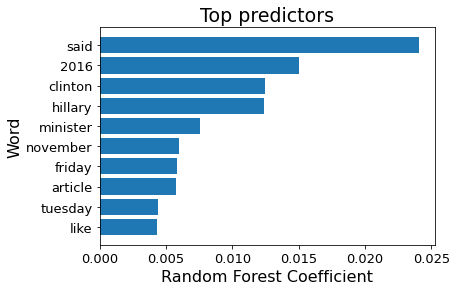

<Figure size 936x936 with 0 Axes>

In [19]:
find_imp_features(X_text, y_text, rf)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


pipe = Pipeline(
        steps= [
        ("tfidf", TfidfVectorizer(lowercase=False, stop_words='english', decode_error='ignore')),
        ("classifier", SVC())
            ])
pipe.fit(X_train.values.astype('U'), y_train) 

feature_names = pipe.named_steps["tfidf"].get_feature_names()
coefs = pipe.best_estimator_.named_steps['tfidf']


# Zip coefficients and names together and make a DataFrame
zipped = zip(feature_names, coefs)
feature_imp = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
feature_imp["abs_value"] = feature_imp["value"].apply(lambda x: abs(x))
feature_imp["colors"] = feature_imp["value"].apply(lambda x: "green" if x > 0 else "red")
feature_imp = feature_imp.sort_values("abs_value", ascending=False)


fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=feature_imp.head(20),
           palette=feature_imp.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)





AttributeError: 'TfidfVectorizer' object has no attribute 'best_estimator_'

**Metrics** 
- ROC-AOC
- confusion matrices

**Lets test the algorithm with some real and fake news texts and see what it predicts**

In [27]:
# support vector machine was the best model so I will use this one for the predictions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

tfidf = TfidfVectorizer(lowercase=False, stop_words='english', decode_error='ignore', ngram_range=(1,1))
    
vector = tfidf.fit(X_train.values.astype('U'))
xv_train = vector.transform(X_train.values.astype('U'))
xv_test = vector.transform(X_test.values.astype('U'))

SV = SVC(random_state=101)

SV.fit(xv_train, y_train)

SVC(random_state=101)

In [23]:
stopwords = nltk.corpus.stopwords.words('english')
lemma = WordNetLemmatizer()

#Function for removing the stopwords and lemmatizing the text 
def text_transform(text):
    #Defining empty string
    string = ""
    
    for word in str(text).split():
        if word not in stopwords:
            string+=lemma.lemmatize(word)+" "
    
    return string

In [28]:
def fake_or_real():

    text = input("Enter text here")

    text_cleaned = text_transform(text)    

    X = vector.transform([text_cleaned])
   
    predicted_class = SV.predict(X)
    print(predicted_class)
    
    if predicted_class == 0:
        print(text)
        return  "Prediction: Fake news!"
    else:
        print(text)
        return "Prediction: real news!"
    

In [29]:
fake_or_real()

[1]
Qualcomm Inc (QCOM.O) said on Tuesday it expects chip sales to Apple Inc (AAPL.O) to dwindle to a trickle in the coming years but predicted brisk growth in chips for autonomous cars and other connected devices, sending shares up 7.9% to a record high close of $181.81


'Prediction: real news!'

In [30]:
fake_or_real()

[0]
"Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam.  In the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI.  The word “unprecedented” has been thrown around so often this election that it ought to be retired. But it’s still unprecedented for the nominee of a major political party to go war with the FBI.  But that’s exactly what Hillary and her people have done. Coma patients just waking up now and watching an hour of CNN from their hospital beds would assume that FBI Director James Comey is Hillary’s opponent in this election.  The FBI is under attack by everyone from Obama to CNN. Hillary’s people have circulated a letter attacking Comey. There are currently more media hit pieces lambasting him than targeting Trump. It wouldn’t be too surprising if the Clintons or their allies were to start running attack ads against the FBI.  The FBI’s leadership is being warned that the entire

'Prediction: Fake news!'

In [31]:
fake_or_real()

[1]
"U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.  Kerry said he expects to arrive in Paris Thursday evening, as he heads home after a week abroad. He said he will fly to France at the conclusion of a series of meetings scheduled for Thursday in Sofia, Bulgaria. He plans to meet the next day with Foreign Minister Laurent Fabius and President Francois Hollande, then return to Washington.  The visit by Kerry, who has family and childhood ties to the country and speaks fluent French, could address some of the criticism that the United States snubbed France in its darkest hour in many years.  The French press on Monday was filled with questions about why neither President Obama nor Kerry attended Sunday’s march, as about 40 leaders of other nations did. Obama was said to have stayed away because his own security needs can be taxing on a country, an

'Prediction: real news!'